In [2]:
import os
import sys

cwd0 = '../config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color, hl, bg, fg
vID.init(cwd0)

**Start at:** Thursday 18 May 2023, 14:23:48  
**Hostname:** localhost.localdomain (Linux)

<p style="text-align: center"><img width="800px" src="../config/svg/PytChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

# Prediction of the solubility of CO<sub>2</sub> in ionic liquids with the Support Vector Regression (SVR) method

<div class="intro">

<b>Reference</b>: 
Z. Song, H. Shi, X. Zhang & T. Zhou (**2020**), Prediction of CO<sub>2</sub> solubility in ionic liquids using machine learning methods, [<i>Chem. Eng. Sci.</i> <b>223</b>: 115752](https://www.doi.org/10.1016/j.ces.2020.115752) 
<br>
<p style="text-align: center"><img width="650px" src="../DS4B-CO2-images/AbstractANNCO2-SongEtal.png" style="margin-left:auto; margin-right:auto" id="img_AbstractSong"></p>
<br>
The main results are graphically reported below.
<br>
<p style="text-align: center"><img width="900px" src="../DS4B-CO2-images/SVRCO2-SongEtal-Results-C.png" style="margin-left:auto; margin-right:auto" id="img_ResultsSong"></p>

</div>
<br>
<div class="rq">

<span style="font-weight:bold">The goal of this exercise is to apply an SVR model optimized with these hyperparameters, ```epsilon=0.001```, ```C=100.0```, ```gamma=0.5```, and to report the results both graphically and in terms of MAE/MSE/$R^2$ </span>    

<span style="color:red; font-weight:bold">Warning!!</span>
<br>This can be a time-consuming learning, that takes almost 10mn with the proposed combination of hyperparameters.
</div>

In [3]:
%matplotlib inline

import numpy as np  # to apply mathematical operations on arrays and matrices
import matplotlib as mp # graphical representation and visualization of data
import matplotlib.pyplot as plt
import pandas as pd   # used for data analysis, works with tabular data (.csv)
import seaborn as sb  # statistical graphics

import os,sys
from IPython.display import display


## Basic data analysis and visualization

### Read the database

In [4]:
dataCO2f='../DS4B-CO2-data/dataCO2.csv'
dataCO2=pd.read_csv(dataCO2f,sep=";",header=0)
display(dataCO2)
# describe() generates descriptive statistics
display(dataCO2.describe().style.format("{0:.2f}"))

,IL,cation,anion,x_CO2,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
0,[BMIM][BF4],[BMIM],[BF4],0.610,363.15,246.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
1,[BMIM][BF4],[BMIM],[BF4],0.500,383.15,235.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[BMIM][BF4],[BMIM],[BF4],0.610,353.15,223.30,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3,[BMIM][BF4],[BMIM],[BF4],0.500,373.15,198.00,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,[BMIM][BF4],[BMIM],[BF4],0.610,343.15,188.50,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10111,[HMIM][Tf2N],[HMIM],[Tf2N],0.592,298.15,35.86,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10112,[HMIM][Tf2N],[HMIM],[Tf2N],0.239,343.15,27.54,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10113,[HMIM][Tf2N],[HMIM],[Tf2N],0.396,298.15,20.15,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0
10114,[HMIM][Tf2N],[HMIM],[Tf2N],0.140,343.15,17.93,1,5,0,0,...,0,0,0,0,0,0,0,0,0,0


,x_CO2,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00
mean,0.33,325.27,54.21,1.18,4.72,0.02,0.02,0.04,0.04,0.01,0.06,0.00,0.00,0.01,0.77,0.01,0.00,0.01,0.09,0.00,0.00,0.01,0.00,0.02,0.05,0.00,0.11,0.02,0.02,0.02,0.11,0.02,0.01,0.07,0.00,0.01,0.43,0.00,0.01,0.01,0.00,0.02,0.01,0.01,0.02,0.05,0.01,0.01,0.00,0.01,0.00,0.01,0.00,0.00
std,0.24,25.24,76.66,0.96,5.48,0.25,0.16,0.20,0.39,0.10,0.28,0.06,0.06,0.10,0.42,0.08,0.07,0.11,0.29,0.06,0.07,0.09,0.06,0.16,0.23,0.06,0.31,0.12,0.15,0.12,0.31,0.14,0.08,0.26,0.04,0.11,0.49,0.03,0.11,0.11,0.05,0.13,0.11,0.10,0.15,0.23,0.09,0.08,0.06,0.10,0.03,0.07,0.04,0.05
min,0.00,243.20,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.14,308.15,10.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.30,323.15,26.80,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.51,342.59,64.76,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,0.95,453.15,499.90,7.00,28.00,3.00,2.00,1.00,5.00,1.00,3.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Data standardization

<div class="intro">

Data will now be standardized, using ```StandardScaler``` from the ```preprocessing``` package provided by the ```scikit learn``` library.

In general terms, standardization is useful when features of the input data have large differences in their ranges of values. The standardized data have mean value equal to 0 and standard deviation equal to 1.

The dataframe is separated into two subsets:
- <code>X</code> the features; given as input to the program
- <code>y</code> the values we want to predict

</div>
<br>
<div class="rq">
    
```y```  is not necessarily standardized in this case, the solubility values vary within a range from 0 to 1</div>

In [5]:
X=dataCO2.drop(['IL','cation','anion','x_CO2'],axis=1)
y = dataCO2['x_CO2']
X_Tmp = X.copy() # for plotting purpose
print("X before standardization")
display(X)
display(X.describe().style.format("{0:.2f}").set_caption("X before standardization :"))
# print("y before standardization")
# display(y)

from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(X.values)
Xsc = scaler.transform(X.values)
X = pd.DataFrame(Xsc, index=X.index, columns=X.columns)

print("scaling done")

print("X after standardization")
display(X)
display(X.describe().style.format("{0:.2f}").set_caption("X after standardization (with scikit-learn):"))

print("y")
display(y)

X before standardization


,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
0,363.15,246.00,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,383.15,235.00,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,353.15,223.30,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,373.15,198.00,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,343.15,188.50,1,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10111,298.15,35.86,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10112,343.15,27.54,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10113,298.15,20.15,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10114,343.15,17.93,1,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00
mean,325.27,54.21,1.18,4.72,0.02,0.02,0.04,0.04,0.01,0.06,0.00,0.00,0.01,0.77,0.01,0.00,0.01,0.09,0.00,0.00,0.01,0.00,0.02,0.05,0.00,0.11,0.02,0.02,0.02,0.11,0.02,0.01,0.07,0.00,0.01,0.43,0.00,0.01,0.01,0.00,0.02,0.01,0.01,0.02,0.05,0.01,0.01,0.00,0.01,0.00,0.01,0.00,0.00
std,25.24,76.66,0.96,5.48,0.25,0.16,0.20,0.39,0.10,0.28,0.06,0.06,0.10,0.42,0.08,0.07,0.11,0.29,0.06,0.07,0.09,0.06,0.16,0.23,0.06,0.31,0.12,0.15,0.12,0.31,0.14,0.08,0.26,0.04,0.11,0.49,0.03,0.11,0.11,0.05,0.13,0.11,0.10,0.15,0.23,0.09,0.08,0.06,0.10,0.03,0.07,0.04,0.05
min,243.20,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,308.15,10.00,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,323.15,26.80,1.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,342.59,64.76,1.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,453.15,499.90,7.00,28.00,3.00,2.00,1.00,5.00,1.00,3.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


scaling done
X after standardization


,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
0,1.500742,2.501854,-0.183557,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
1,2.293124,2.358359,-0.183557,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
2,1.104551,2.205733,-0.183557,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
3,1.896933,1.875695,-0.183557,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
4,0.708360,1.751768,-0.183557,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10111,-1.074499,-0.239419,-0.183557,0.050373,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
10112,0.708360,-0.347953,-0.183557,0.050373,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
10113,-1.074499,-0.444355,-0.183557,0.050373,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
10114,0.708360,-0.473315,-0.183557,0.050373,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561


,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],CH=CH,CH=CH2,[Im13],[MIm],[MMIM],[Py],[MPy],[MPyrro],[MPip],[NH3],[NH2],[NH],[N],[P],[S],[BF4],[Cl],[DCA],[NO3],[PF6],[SCN],[TCB],[C(CN)3],[HSO4],[FSA],[Tf2N],[BETA],[FOR],[TFA],[C3F7CO2],[MeSO4],[EtSO4],[MDEGSO4],[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
count,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00,10116.00
mean,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-3.25,-0.71,-1.22,-0.86,-0.08,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.06,-0.10,-1.83,-0.08,-0.07,-0.11,-0.32,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.08,-0.28,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.03,-0.08,-0.04,-0.05
25%,-0.68,-0.58,-0.18,-0.31,-0.08,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.06,-0.10,0.55,-0.08,-0.07,-0.11,-0.32,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.08,-0.28,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.03,-0.08,-0.04,-0.05
50%,-0.08,-0.36,-0.18,-0.31,-0.08,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.06,-0.10,0.55,-0.08,-0.07,-0.11,-0.32,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.08,-0.28,-0.04,-0.12,-0.86,-0.03,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.03,-0.08,-0.04,-0.05
75%,0.69,0.14,-0.18,0.05,-0.08,-0.12,-0.21,-0.10,-0.10,-0.20,-0.06,-0.06,-0.10,0.55,-0.08,-0.07,-0.11,-0.32,-0.06,-0.07,-0.09,-0.06,-0.16,-0.24,-0.06,-0.35,-0.13,-0.15,-0.13,-0.35,-0.14,-0.08,-0.28,-0.04,-0.12,1.16,-0.03,-0.12,-0.11,-0.05,-0.13,-0.11,-0.10,-0.15,-0.24,-0.09,-0.08,-0.06,-0.11,-0.03,-0.08,-0.04,-0.05
max,5.07,5.81,6.05,4.25,11.81,12.23,4.77,12.61,9.96,10.49,15.49,16.07,9.63,0.55,12.44,14.48,9.37,3.09,16.73,14.48,11.34,16.97,6.27,4.20,16.07,2.84,7.99,6.71,7.89,2.84,6.90,12.73,3.52,27.88,8.60,1.16,30.31,8.66,8.90,18.98,7.47,9.37,9.72,6.56,4.15,11.34,13.06,16.73,9.45,29.02,13.28,23.69,21.93


y


0        0.610
1        0.500
2        0.610
3        0.500
4        0.610
         ...  
10111    0.592
10112    0.239
10113    0.396
10114    0.140
10115    0.139
Name: x_CO2, Length: 10116, dtype: float64

/tmp/ipykernel_18354/2043957100.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax00=plt.subplot(gs[0,0], title="Before standardization")


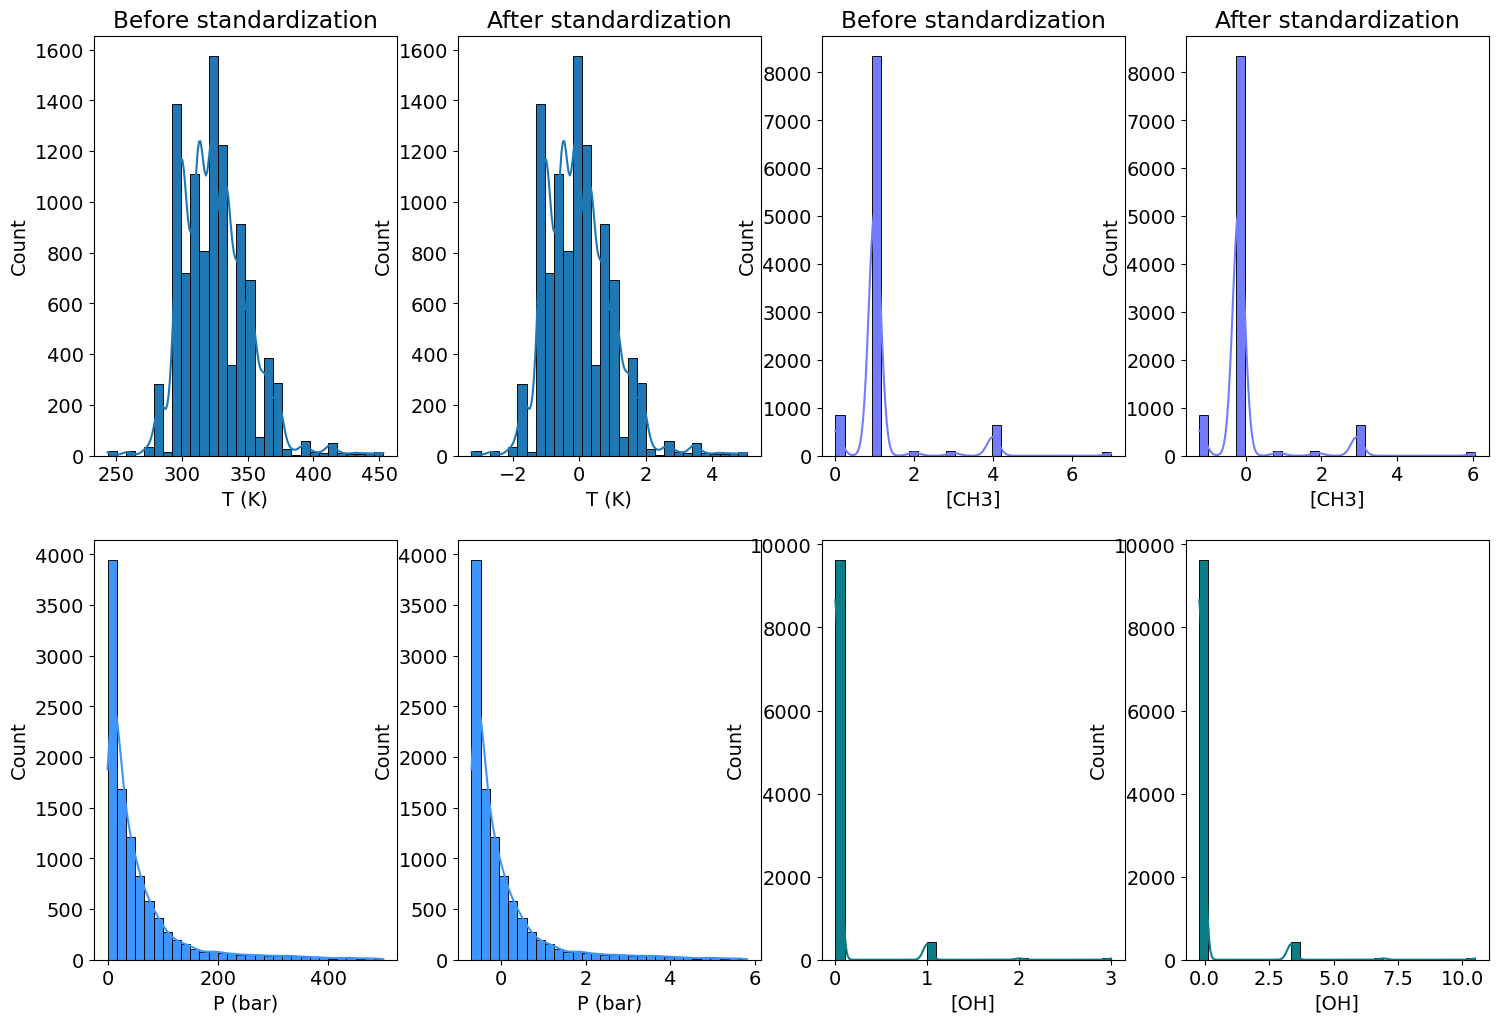

In [6]:
#######################################################################################
# graphic representation of the previous tables
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

nbins=30
fig = plt.figure(figsize=(18, 12))
plt.rcParams["font.size"] = (14) #font size
plt.tick_params(axis='x',labelsize = 16)
plt.tick_params(axis='y',labelsize = 12)
gs = gridspec.GridSpec(2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 1])

ax00=plt.subplot(gs[0,0], title="Before standardization")
fig00=sb.histplot(data=X_Tmp,x="T (K)", bins=nbins, kde=True, color="#1f77b4", alpha=1.0)
ax10=plt.subplot(gs[1,0])
fig10=sb.histplot(data=X_Tmp,x="P (bar)", bins=nbins, kde=True, color="#3e95ff", alpha=1.0)
ax01=plt.subplot(gs[0,1], title="After standardization")
fig01=sb.histplot(data=X,x="T (K)", bins=nbins, kde=True, color="#1f77b4", alpha=1.0)
ax11=plt.subplot(gs[1,1])
fig11=sb.histplot(data=X,x="P (bar)", bins=nbins, kde=True, color="#3e95ff", alpha=1.0)

ax02=plt.subplot(gs[0,2], title="Before standardization")
fig02=sb.histplot(data=X_Tmp,x="[CH3]", bins=nbins, kde=True, color="#737cff", alpha=1.0)
ax12=plt.subplot(gs[1,2])
fig12=sb.histplot(data=X_Tmp,x="[OH]", bins=nbins, kde=True, color="#0a7d87", alpha=1.0)
ax03=plt.subplot(gs[0,3], title="After standardization")
fig03=sb.histplot(data=X,x="[CH3]", bins=nbins, kde=True, color="#737cff", alpha=1.0)
ax13=plt.subplot(gs[1,3])
fig13=sb.histplot(data=X,x="[OH]", bins=nbins, kde=True, color="#0a7d87", alpha=1.0)


<div class="intro">

<code>X</code> and <code>y</code> are furtherly split into training and test sets</div>

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [8]:
X_train

,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
8698,-0.084022,-0.681135,-0.183557,-0.496769,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
1961,-1.074103,-0.576762,-1.223230,-0.496769,-0.084667,-0.120283,-0.209673,7.527123,9.957832,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
9374,-0.084022,0.606418,-0.183557,0.050373,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
3953,-1.260709,-0.428049,-0.183557,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
1883,-0.084814,0.077444,-0.183557,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,-1.668785,-0.615897,-0.183557,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
7813,-0.084022,-0.589820,1.895791,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
905,-0.084022,-0.661424,-0.183557,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
5192,0.708360,-0.626463,-1.223230,-0.496769,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,3.358938,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561


In [9]:
X_test

,T (K),P (bar),[CH3],[CH2],[CH],[OCH2],[OCH3],[CF2],[CF3],[OH],...,[MeSO3],[TfO],[NfO],[TDfO],[TOS],[C12PhSO3],[DMPO4],[DEPO4],[DBPO4],[methide]
6020,-0.876404,-0.624220,-0.183557,0.415134,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
6201,1.507081,0.163541,2.935465,4.245129,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
8916,-0.084022,-0.642770,-1.223230,-0.314389,-0.084667,6.056288,4.769327,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
916,-1.074499,-0.674469,-0.183557,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
3484,1.896933,1.212227,-0.183557,-0.679150,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6691,1.104551,0.517712,-0.183557,0.597515,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
5729,0.312169,0.271162,-0.183557,0.415134,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
7701,-0.480213,-0.655032,-1.223230,-0.679150,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,-0.240932,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561
2489,0.763827,0.310297,-0.183557,-0.314389,-0.084667,-0.120283,-0.209673,-0.097226,-0.100423,-0.204298,...,-0.152529,4.150545,-0.08815,-0.076593,-0.059761,-0.105809,-0.034462,-0.075277,-0.04222,-0.04561


In [10]:
y_train

8698    0.0379
1961    0.2790
9374    0.4570
3953    0.5012
1883    0.6020
         ...  
2895    0.1580
7813    0.1412
905     0.0401
5192    0.0350
235     0.4576
Name: x_CO2, Length: 8092, dtype: float64

In [11]:
y_test

6020    0.2019
6201    0.6010
8916    0.0677
916     0.0458
3484    0.5700
         ...  
6691    0.6370
5729    0.6779
7701    0.0843
2489    0.4574
2951    0.0450
Name: x_CO2, Length: 2024, dtype: float64

## Fitting (aka "learning process") with best hyperparameters

```epsilon=0.001```, ```C=100.0```, ```gamma=0.5```

<div class="rq"> <span style="color:red; font-weight:bold">Warning!!</span>
<br>This can be a time-consuming learning, that takes almost 10mn with the proposed combination of hyperparameters.
</div>

### Optimization of the model

In [12]:
from sklearn.svm import SVR
vID.chrono_start()
regressor1 = SVR(kernel = 'rbf', epsilon=0.001, C=100.0, gamma=0.5)
regressor1.fit(X_train, y_train.values.ravel())
vID.chrono_show()


Duration :  00:06:46 921ms


### MAE, MSE and R2

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

ytrain_pred=regressor1.predict(X_train)
msetr=mean_squared_error(y_train,ytrain_pred)
maetr=mean_absolute_error(y_train,ytrain_pred)
r2tr=r2_score(y_train,ytrain_pred)

print(f"{hl.BOLD}Training set{hl.OFF}")
print(f"MSE = {msetr:.2e}")
print(f"MAE = {maetr:.2e}")
print(f"R2 = {r2tr:.2f}")

y_pred=regressor1.predict(X_test)
msett=mean_squared_error(y_test,y_pred)
maett=mean_absolute_error(y_test,y_pred)
r2tt=r2_score(y_test,y_pred)

print(f"{hl.BOLD}Test set{hl.OFF}")
print(f"MSE = {msett:.2e}")
print(f"MAE = {maett:.2e}")
print(f"R2 = {r2tt:.2f}")


Training set
MSE = 5.77e-04
MAE = 1.10e-02
R2 = 0.99
Test set
MSE = 9.07e-04
MAE = 1.56e-02
R2 = 0.98


### Predicted vs. actual solubility values

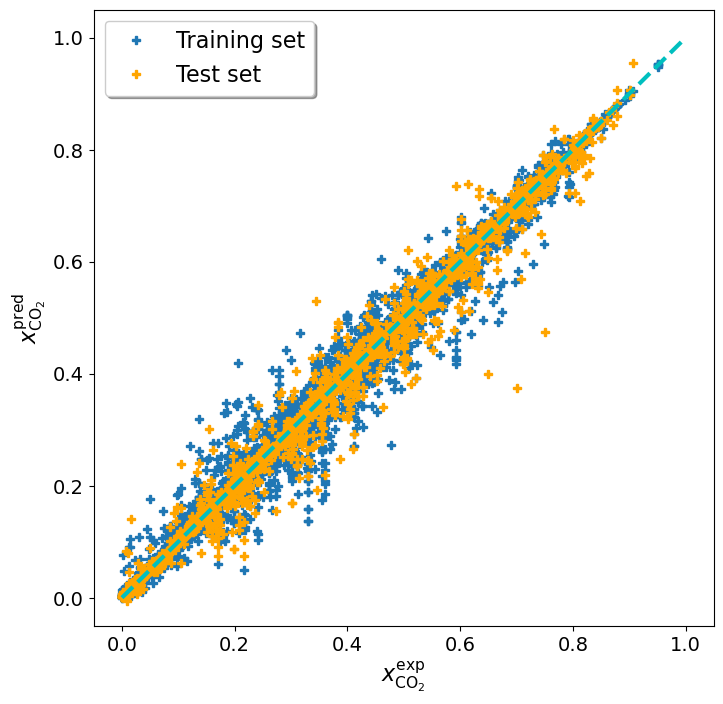

In [36]:
xD=[0,1]
yD=[0,1]
fig = plt.figure(figsize=(8, 8))
plt.rcParams["font.size"] = (18) #font size
plt.tick_params(labelsize = 14)
plt.plot(y_train,ytrain_pred,'P',color="#1f77b4",label='Training set')
plt.plot(y_test,y_pred,'P',color="orange",label='Test set')
plt.plot(xD,yD,'c',linestyle='--',lw=3)
plt.xlabel('$x_{\mathrm{CO_2}}^{\mathrm{exp}}$',fontsize=16)
plt.ylabel('$x_{\mathrm{CO_2}}^{\mathrm{pred}}$',fontsize=16)
plt.xlim(-0.05,1.05);plt.ylim(-0.05,1.05) 
plt.legend( shadow=True, fontsize='16')
plt.savefig('../DS4B-CO2-images/SVR-CO2-bestHyperparameters-xpred_vs_xexp.png',dpi=300,bbox_inches='tight',transparent=True)
plt.show()

### Error distribution

In [20]:
diffytest=y_pred-y_test
diffytrain=ytrain_pred-y_train

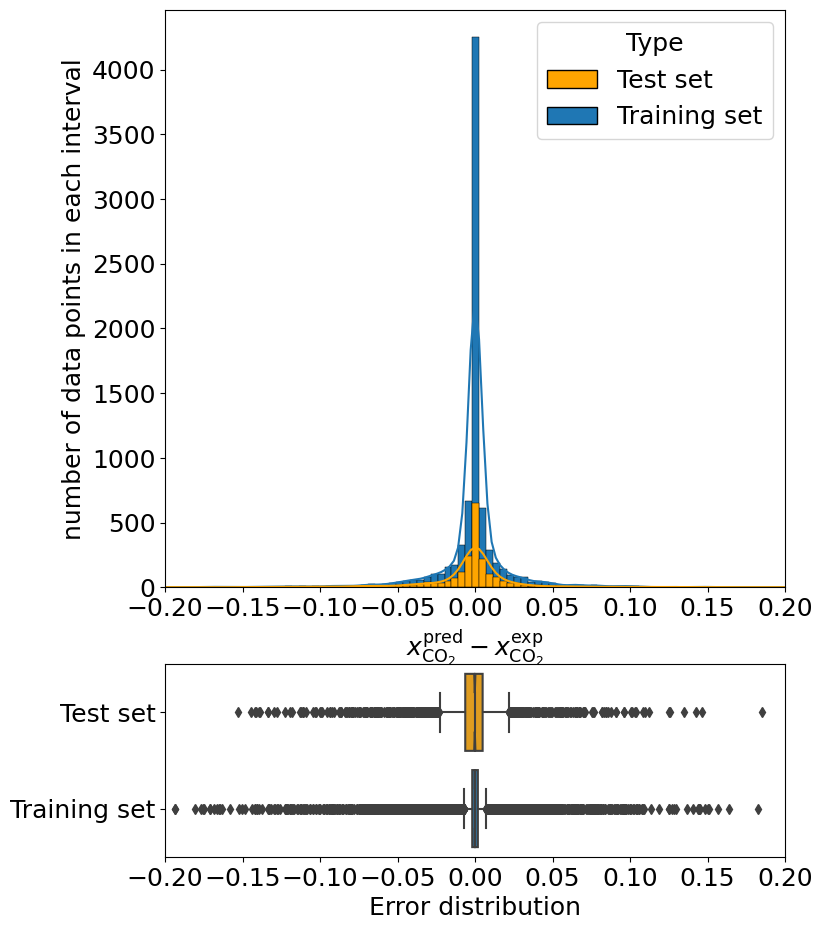

In [37]:
import matplotlib.gridspec as gridspec
xlim=0.2
nbins=120

df1 = pd.DataFrame(
    {
        "Error distribution": diffytest,
        "Type": 'Test set'    },
)
#display(df1)
df2 = pd.DataFrame(
    {
        "Error distribution": diffytrain,
        "Type": 'Training set'    },
)
distrib=pd.concat([df1,df2],ignore_index=True)
plt.rcParams["figure.figsize"] = (8,11) #graphic size
plt.rcParams["font.size"] = (18) #font size
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
plt.subplot(gs[0])
fig1=sb.histplot(data=distrib,x="Error distribution", hue="Type", bins=nbins, kde=True,palette=['Orange','#1f77b4'], alpha=1.0)
plt.xlabel("$x_{\mathrm{CO_2}}^{\mathrm{pred}}-x_{\mathrm{CO_2}}^{\mathrm{exp}}$")
plt.ylabel("number of data points in each interval")
plt.xlim(-xlim,xlim)
plt.subplot(gs[1])
plt.xlim(-xlim,xlim)
fig2=sb.boxplot(data=distrib, x="Error distribution", y="Type",notch=True, orient = 'h',palette=['Orange','#1f77b4'])
plt.xlabel("Error distribution")
fig2.set(ylabel=None)

plt.savefig('../DS4B-CO2-images/SVR-CO2-bestHyperparameters-ErrorsPlot.png',dpi=300,bbox_inches='tight',transparent=True)

## Conclusion


<div class="rq">
    
The support vector regression (SVR) model, tuned with optimal hyperparameters, is slightly more accurate than the one developped in Sang *et al*. As a consequence, and on the contrary to Sang *et al.* conclusions, SVR slightly outperforms ANN, an expected behaviour for small data sets. </div>

In [38]:
vID.end(cwd0)

**End at:** Thursday 18 May 2023, 15:01:46  
**Duration:** 00:37:58 569ms

<p style="text-align: center"><img width="800px" src="../config/svg/logoEnd.svg" style="margin-left:auto; margin-right:auto"/></p>